In [70]:
%pylab inline --no-import-all
plt.style.use('ggplot')
matplotlib.rc('image', origin='lower', cmap='magma')
matplotlib.rc('axes', grid=False)
SymLogNorm = matplotlib.colors.SymLogNorm
LogNorm = matplotlib.colors.LogNorm
from astropy.io import fits
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [45]:
psfs = fits.open('./nicmos_f160w_psf_ref.fits')
images = fits.open('./nicmos_f160w_data.fits')

In [47]:
psf_datacube = psfs[1].data
psf_datacube.shape

(558, 80, 80)

In [48]:
images_datacube = images[1].data
images_datacube.shape

(702, 80, 80)

In [11]:
from sklearn import decomposition
import datetime

In [12]:
def factorize(data_cube, n_components, strategy='PCA'):
    all_real_cube = data_cube.copy()
    # since our resulting model won't need to reproduce bad pixels, this should be reasonable:
    all_real_cube[np.isnan(data_cube)] = 0.0
    zz, yy, xx = all_real_cube.shape
    all_real_cube = all_real_cube.reshape((zz, yy * xx))
    ts = datetime.datetime.now()
    print("Beginning {} for {} components".format(strategy, n_components))
    if strategy == 'NMF':
        fitter = decomposition.NMF(n_components=n_components)
    elif strategy == 'PCA':
        fitter = decomposition.PCA(n_components=n_components)
    elif strategy == 'FastICA':
        fitter = decomposition.FastICA(n_components=n_components)
    else:
        raise ValueError("Select strategy from among NMF, PCA, and ICA")
    fitter.fit(all_real_cube)
    print("Finished in {}".format(datetime.datetime.now() - ts))
    return fitter

In [80]:
n_components = 50
pca_fitter = factorize(psf_datacube, n_components=n_components, strategy='FastICA')

Beginning FastICA for 50 components
Finished in 0:00:00.228017


In [81]:
import matplotlib.gridspec as gridspec
from itertools import product

def image_grid(cube, columns, colorbar=False, cmap=None, fig=None):
    if fig is None:
        fig = plt.gcf()
    rows = (
        cube.shape[0] // columns
        if cube.shape[0] % columns == 0
        else cube.shape[0] // columns + 1
    )
    gs = gridspec.GridSpec(rows, columns)
    for idx, (row, col) in enumerate(product(range(rows), range(columns))):
        ax = fig.add_subplot(gs[row, col])
        im = ax.imshow(cube[idx], cmap=cmap)
        if colorbar:
            add_colorbar(im)
    return fig

def visualize_components(fitter, shape, columns=2):
    cube = fitter.components_.reshape(shape)
    fig = plt.figure(figsize=(8, cube.shape[0] // columns * 5))
    return image_grid(cube, columns)

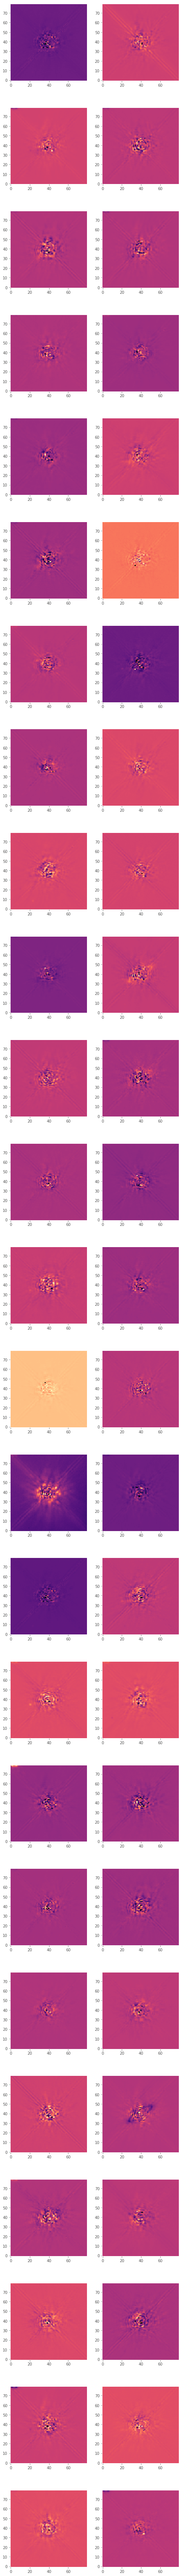

In [82]:
_ = visualize_components(pca_fitter, (n_components,) + psf_datacube.shape[1:])

array([[  9.14698816,  15.59325124,  10.1608466 , ...,  -7.25602914,
          0.57020147,  -1.01250136],
       [  4.45021765,   9.84863893,  14.12413126, ...,   1.57930621,
         -1.15693552,  -7.00129746],
       [  7.85761364,   6.44964055,   9.04964354, ...,   3.28496917,
         -6.10473046,  -6.8813512 ],
       ..., 
       [ 14.10395301,  20.75061253,  17.85170913, ...,  11.65304402,
          2.61929839,   0.95611433],
       [ 19.74053466,  19.23300383,  11.84739089, ...,  15.01806157,
         10.30204221,   1.10542647],
       [ 17.55038147,  12.99820658,  14.7784155 , ...,   9.61082619,
         17.22587425,  10.05764823]])

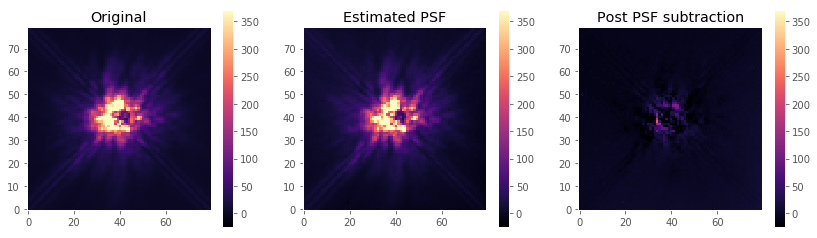

In [94]:
def estimate_psf(image, fitter, display=False, vmin_percentile=1, vmax_percentile=99):
    coeffs = fitter.transform([image.flatten() - np.average(image),])
    psf_estimate = fitter.inverse_transform(coeffs)[0].reshape(image.shape) + np.average(image)
    difference = image - psf_estimate
    vmin, vmax = np.percentile(difference, vmin_percentile), np.percentile(image, vmax_percentile)
    plt.subplot(1,3,1)
    plt.imshow(image, vmin=vmin, vmax=vmax)
    plt.colorbar()
    plt.title('Original')
    plt.subplot(1,3,2)
    plt.imshow(psf_estimate, vmin=vmin, vmax=vmax)
    plt.colorbar()
    plt.title('Estimated PSF')
    plt.subplot(1,3,3)
    plt.imshow(difference, vmin=vmin, vmax=vmax)
    plt.colorbar()
    plt.title('Post PSF subtraction')
    return psf_estimate

plt.figure(figsize=(14, 4))
estimate_psf(images_datacube[0], fitter=pca_fitter)

In [58]:
def subtract_estimated_psf(image, fitter, display=False):
    psf_estimate = estimate_psf(image, fitter, display=display)

In [55]:
image = images_datacube[0]
coeffs = pca_fitter.transform([image.flatten(),])
coeffs

array([[ 0.01756384, -0.00598684,  0.03820918, -0.02569561,  0.00215216,
        -0.03020552, -0.00180873, -0.01699958, -0.00755172, -0.03160504]])

In [56]:
pca_fitter.inverse_transform(coeffs)

array([[ 13.45143921,  20.26612944,  11.7935566 , ...,  14.53744451,
         25.44591836,  16.14472806]])

In [95]:
pwd

'/home/jlong/datamining/Ast-502-final-project'